In [1]:
import psycopg2 
import pandas as pd
import json
import requests
import plotly as py
import plotly.express as px
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import statsmodels.stats.api
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import probplot,binom

In [2]:
stats_sql = """
select business.name,business.lon,business.lat,business.clusterid,business.state,counties.county,business.stars,business.revcount,
counties.avg_income,count(categories.cat) as ct_cat
from business 
inner join fipzip
on business.pcode = fipzip.pcode
inner join counties
on fipzip.fcode = counties.fcode
inner join category
on business.bid =category.bid
inner join categories
on category.cid=categories.cid
group by business.name,business.lon,business.lat,business.clusterid,business.state,counties.county,business.stars,business.revcount,
counties.avg_income
"""
conn = psycopg2.connect(host="141.100.70.97",user ="sync3",password="sync3",dbname="sync3",port=5432)
stats_df=pd.read_sql_query(stats_sql,conn)

In [39]:
#Subset data according to clusters(Cluster 3 and 8 not relevant)
AZ_1 = stats_df[stats_df["clusterid"]==1]
OH_2 = stats_df[stats_df["clusterid"]==2]
NY_4 = stats_df[stats_df["clusterid"]==4]
NC_5 = stats_df[stats_df["clusterid"]==5]
NV_6 = stats_df[stats_df["clusterid"]==6]
WI_7 = stats_df[stats_df["clusterid"]==7]
PA_9 = stats_df[stats_df["clusterid"]==9]
IL_10 = stats_df[stats_df["clusterid"]==10]
#New columns for statistical analysis
stats_df["rounded_stars"] = stats_df["stars"].apply(lambda x: int(x))#Rounded_stars for binomial distribution
stats_df["binom_stars"] = stats_df["rounded_stars"].apply(lambda x: x-1)#Try see if stars can be set to 0 instead of one star as minimum
corrected_stats_df = stats_df[~stats_df.clusterid.isin([3,8])]

In [4]:
#Anova table for relationship stars~clusterid
model=ols("stars~C(clusterid)",data=corrected_stats_df).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
anova_table
#Es gibt einen Unterschied zwischen verschiedenen Clusters im Bezug auf Stars

,sum_sq,df,F,PR(>F)
C(clusterid),921.204924,7.0,123.820054,2.444751e-182
Residual,162475.038147,152869.0,NaN,NaN


In [7]:
#Plot Boxplot of rounded_stars with Plotly
fig =px.box(stats_df, x="clusterid",y="rounded_stars")
fig.write_html("box.html",auto_open=True)

In [5]:
##Comparison between each Cluster in terms of stars with tukey test
tukey = pairwise_tukeyhsd(endog=corrected_stats_df['stars'],
                          groups=corrected_stats_df['clusterid'],
                          alpha=0.05)
print(tukey)
#Zeilen mit True in der Spalte reject zeigen, dass der Unterschied zwischen den Means/Mittelwerte signifikant ist

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.1904  0.001  -0.218 -0.1629   True
     1      4  -0.3563 0.7104 -1.0226    0.31  False
     1      5  -0.1583  0.001 -0.1851 -0.1314   True
     1      6   0.0064    0.9 -0.0139  0.0268  False
     1      7  -0.0745  0.001 -0.1186 -0.0305   True
     1      9  -0.0999  0.001 -0.1308  -0.069   True
     1     10  -0.2544  0.001  -0.325 -0.1838   True
     2      4  -0.1659    0.9 -0.8325  0.5008  False
     2      5   0.0322 0.0799 -0.0018  0.0662  False
     2      6   0.1969  0.001  0.1677  0.2261   True
     2      7   0.1159  0.001  0.0672  0.1647   True
     2      9   0.0905  0.001  0.0532  0.1278   True
     2     10  -0.0639 0.1446 -0.1376  0.0097  False
     4      5   0.1981    0.9 -0.4685  0.8647  False
     4      6   0.3628  0.693 -0.3036  1.0291  False
     4      7   0.2818    0.9 -0.3857  0.9493 

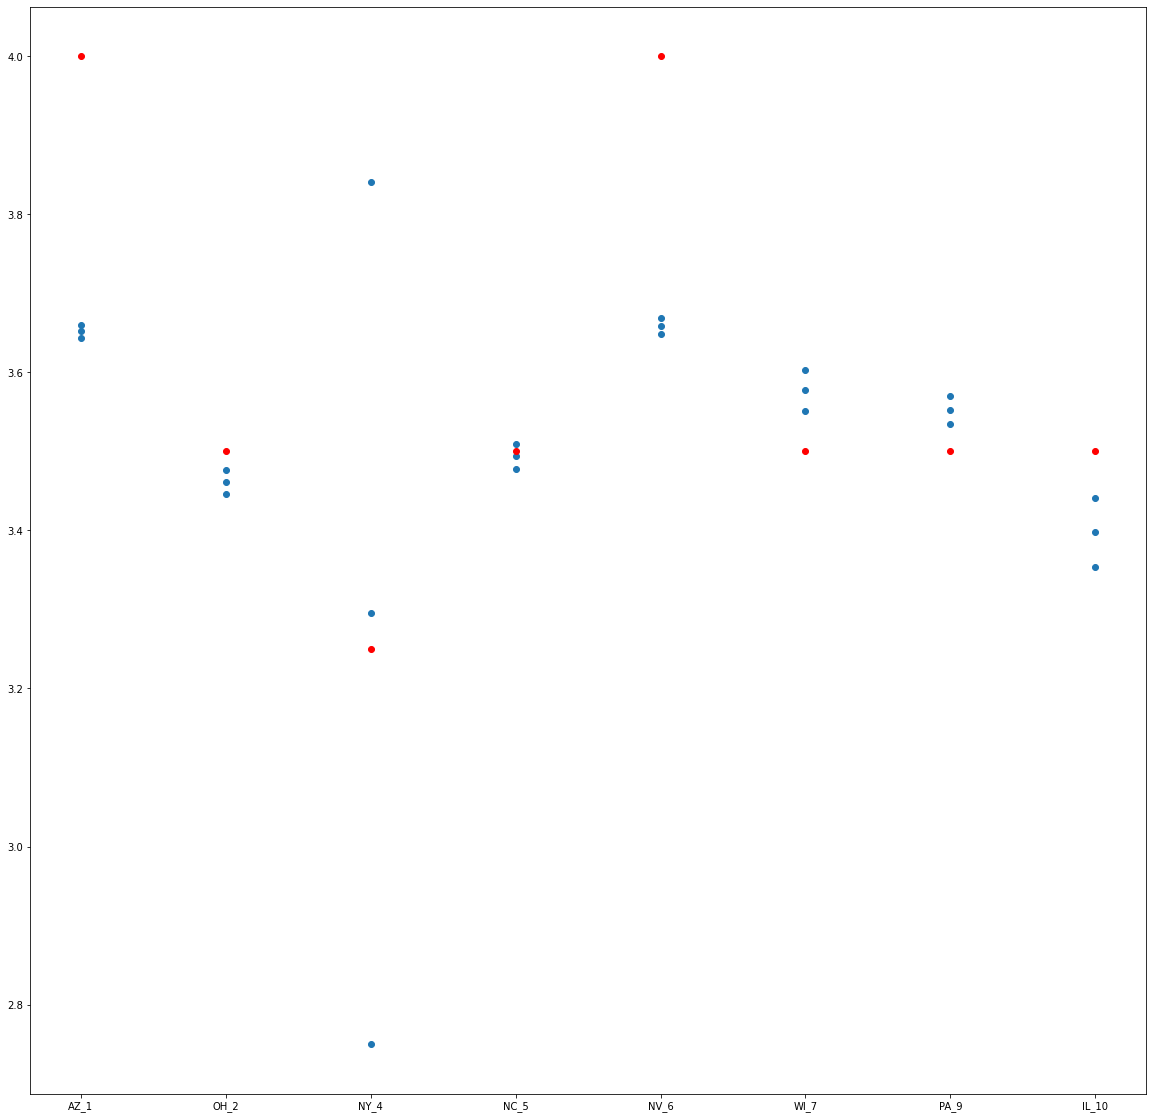

In [9]:
#Confirmation of Tukey test with plot of median and mean confidence interval
confint=[]
median =[]
for i in [AZ_1,OH_2,NY_4,NC_5,NV_6,WI_7,PA_9,IL_10]:
    span = statsmodels.stats.api.DescrStatsW(i["stars"]).tconfint_mean()
    trio = [span[0],i["stars"].mean(),span[1]]
    median.append(i["stars"].median())
    confint.extend(trio)
multiples =[]
for i in ["AZ_1","OH_2","NY_4","NC_5","NV_6","WI_7","PA_9","IL_10"]:
    cluster_mul = [i,i,i]
    multiples.extend(cluster_mul)
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.scatter(x=multiples,y=confint)
plt.scatter(x=["AZ_1","OH_2","NY_4","NC_5","NV_6","WI_7","PA_9","IL_10"],y=median,c="red")

In [10]:
##Comparison between each Cluster in terms of stars with tukey test

tukey = pairwise_tukeyhsd(endog=corrected_stats_df['revcount'],
                          groups=corrected_stats_df['clusterid'],
                          alpha=0.05)
print(tukey)
#Zeilen mit True in der Spalte reject zeigen, dass der Unterschied zwischen den Means/Mittelwerte signifikant ist

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     1      2 -16.7188  0.001  -20.4501 -12.9875   True
     1      4 -29.6999    0.9 -119.8569   60.457  False
     1      5 -10.0579  0.001  -13.6925  -6.4234   True
     1      6  29.8479  0.001   27.0986  32.5973   True
     1      7 -12.8709  0.001  -18.8316  -6.9101   True
     1      9 -12.0316  0.001   -16.211  -7.8522   True
     1     10 -16.9927  0.001  -26.5512  -7.4343   True
     2      4 -12.9811    0.9 -103.1825  77.2203  False
     2      5   6.6609  0.001    2.0547  11.2671   True
     2      6  46.5668  0.001   42.6214  50.5121   True
     2      7    3.848 0.6227   -2.7503  10.4462  False
     2      9   4.6872 0.0911     -0.36   9.7344  False
     2     10  -0.2739    0.9  -10.2424   9.6946  False
     4      5   19.642    0.9  -70.5554 109.8394  False
     4      6  59.5479 0.4818  -30.6182  149.714

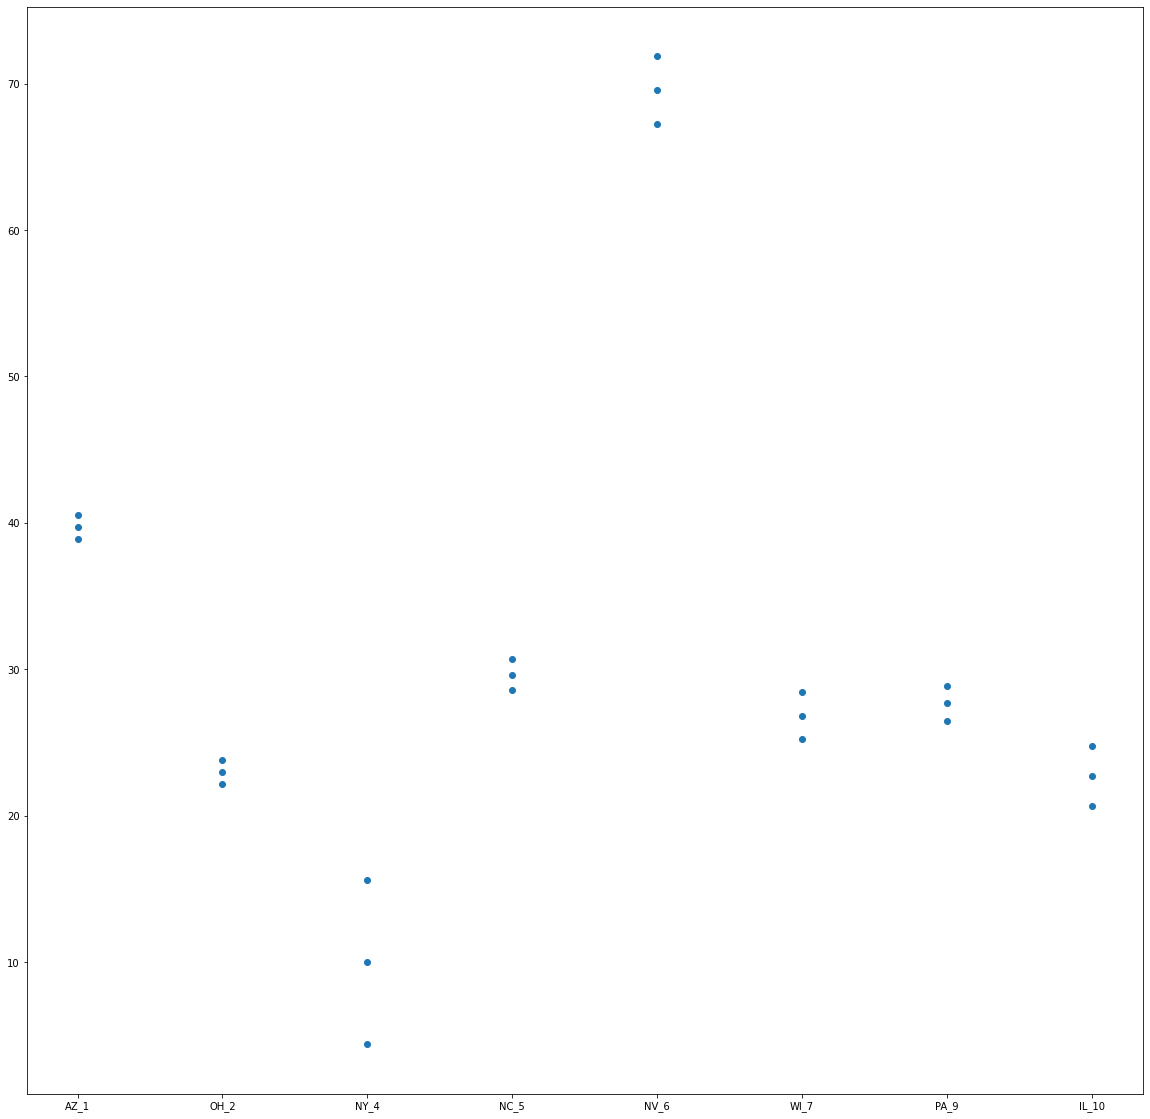

In [11]:
#Confirmation of Tukey test with plot of  mean confidence interval

confint=[]
for i in [AZ_1,OH_2,NY_4,NC_5,NV_6,WI_7,PA_9,IL_10]:
    span = statsmodels.stats.api.DescrStatsW(i["revcount"]).tconfint_mean()
    trio = [span[0],i["revcount"].mean(),span[1]]
    confint.extend(trio)
multiples =[]
for i in ["AZ_1","OH_2","NY_4","NC_5","NV_6","WI_7","PA_9","IL_10"]:
    cluster_mul = [i,i,i]
    multiples.extend(cluster_mul)
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.scatter(x=multiples,y=confint)

In [11]:
#Make class for comparing data with theoretical binomial distribution
class BinomialDistribution:
    def __init__(self,
                 n:int,
                 x:pd.DataFrame):
        
        self.x = x
        self.n = n
        self.p = np.array([0,
                           len(x[x["rounded_stars"]==1])/len(x),
                           len(x[x["rounded_stars"]==2])/len(x),
                           len(x[x["rounded_stars"]==3])/len(x),
                           len(x[x["rounded_stars"]==4])/len(x),
                           len(x[x["rounded_stars"]==5])/len(x)])
        self.p_dach = np.array(x).sum()/(len(x)*n) 
        self.theo_binomial=self.theoretical_binomial()
    
    def theoretical_binomial(self):
        from math import comb
        theoretical_probs = []
        for i in range(0,self.n+1):
            prob = comb(self.n,i)*(self.p_dach)**(i)*(1-self.p_dach)**(self.n -i) 
            theoretical_probs.append(prob)
        return theoretical_probs
    
    #def plot_binomial_w_data(self):
     #   plt.li

theoretische Wahrscheinlichkeit, einen Stern zu bekommen: 0.6753717040496608


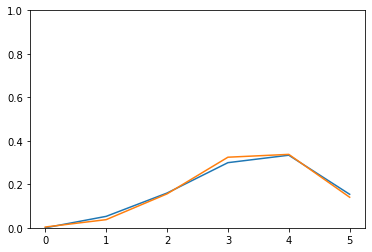

In [17]:
plt.plot(BinomialDistribution(5,corrected_stats_df[["rounded_stars"]]).p)
plt.plot(BinomialDistribution(5,corrected_stats_df[["rounded_stars"]]).theoretical_binomial())
plt.ylim(0,1)
print("theoretische Wahrscheinlichkeit, einen Stern zu bekommen: "+str(BinomialDistribution(5,corrected_stats_df[["rounded_stars"]]).p_dach))
#shows almost perfect fit
#same results when binom_stars used (change )

((array([0., 0., 0., ..., 5., 5., 5.]),
  array([1, 1, 1, ..., 5, 5, 5], dtype=int64)),
 (1.013050090082904, -0.04406830788646232, 0.9769933083199368))

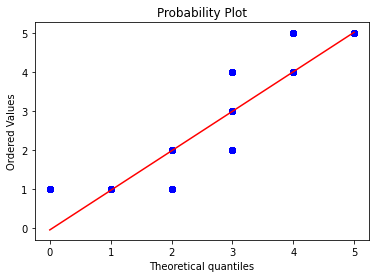

In [18]:
stats.probplot(np.array(corrected_stats_df["rounded_stars"]), dist="binom",sparams=(5,BinomialDistribution(5,corrected_stats_df[["rounded_stars"]]).p_dach), plot=plt)


In [22]:
##Binomial Verteilung mit Daten von verschiedenen Clusters fitten
clusters=["AZ_1","OH_2","NY_4","NC_5","NV_6","WI_7","PA_9","IL_10"]
for index,i in enumerate([AZ_1,OH_2,NY_4,NC_5,NV_6,WI_7,PA_9,IL_10]):
    print(f"theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster {clusters[index]}: "+str(BinomialDistribution(5,i[["rounded_stars"]]).p_dach))
##Restaurants in Nevada haben eine höhere Wahrscheinlichkeit einen Stern zu bekommen

theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster AZ_1: 0.686966161992223
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster OH_2: 0.6453536158989143
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster NY_4: 0.6090909090909091
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster NC_5: 0.6525464556090846
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster NV_6: 0.6871225965869604
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster WI_7: 0.6688775510204081
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster PA_9: 0.6636525974025974
theoretische Wahrscheinlichkeit, um einen Stern zu bekommen für Cluster IL_10: 0.6316518298714144


In [31]:
#Eine Kopie von corrected_stats_df erstellen und eine neue Spalte ["const"] hinzufügen
stats_df["const"]=1

In [17]:
##Poisson Verteilung mit Daten fitten, lambda (in diesem Fall revcount pro Business) wird mit ct_cat (Anzahl an Categories) und stars gefittet
poisson_reg = sm.Poisson(corrected_stats_df[['revcount']], corrected_stats_df[["stars","ct_cat","const"]],
                              missing='drop').fit()
print(poisson_reg.summary())
##Anzahl der Kategorien hat einen höheren Einfluss auf lambda

Optimization terminated successfully.
         Current function value: 55.553626
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:               revcount   No. Observations:               152877
Model:                        Poisson   Df Residuals:                   152874
Method:                           MLE   Df Model:                            2
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:                 0.04488
Time:                        20:53:01   Log-Likelihood:            -8.4929e+06
converged:                       True   LL-Null:                   -8.8919e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
stars          0.0900      0.000    226.329      0.000       0.089       0.091
ct_cat         0.1292      0

In [28]:

poisson_reg = sm.Poisson(corrected_stats_df[['revcount']], corrected_stats_df[["const"]],
                              missing='drop').fit()
print(poisson_reg.params.const)

Optimization terminated successfully.
         Current function value: 58.164043
         Iterations 1
3.7540714734825498


[]

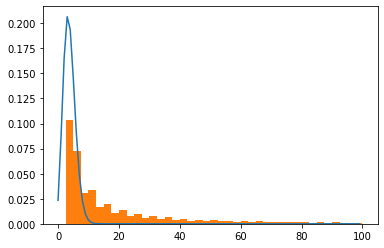

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

t = np.arange(0, 100, 1)
d = np.exp(-3.7541)*np.power(3.7541, t)/factorial(t)

plt.plot(t, d)

plt.hist(np.array(corrected_stats_df["revcount"]),bins=40,range = (0,100),density=True)

plt.plot()

((array([17., 18., 19., ..., 72., 73., 75.]),
  array([    3,     3,     3, ...,  7383,  9264, 10129], dtype=int64)),
 (10.95447858006268, -425.0020667839269, 0.5094618958755482))

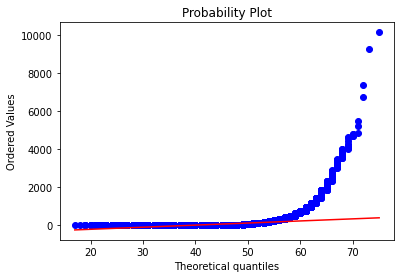

In [44]:
###QQplot: Vergleich zwischen Datensatz(revcount) und theoretischen Quantilen der Poisson Verteilung
stats.probplot(np.array(corrected_stats_df["revcount"]), dist="poisson",sparams=(42.69455837045468), plot=plt)
###Große Abweichungen bei großen revcounts

In [81]:
corrected_stats_df["revcount"].mean()

42.69455837045468

((array([17., 18., 19., ..., 72., 73., 75.]),
  array([    3,     3,     3, ...,  7383,  9264, 10129], dtype=int64)),
 (10.95447858006268, -425.0020667839269, 0.5094618958755482))

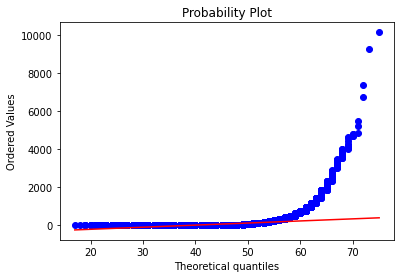

In [54]:
stats.probplot (np.array(corrected_stats_df["revcount"]), dist = 'poisson', sparams = (42.69455837045468), plot = plt)

In [41]:
clusters=["AZ_1","OH_2","NY_4","NC_5","NV_6","WI_7","PA_9","IL_10"]
for index,i in enumerate([AZ_1,OH_2,NY_4,NC_5,NV_6,WI_7,PA_9,IL_10]):
    poisson_reg = sm.Poisson(i[['revcount']], i[["const"]],
                              missing='drop').fit()
    print(f"revcount pro Business in Cluster {clusters[index]} : " + str(poisson_reg.params.const))
###Nevada hat die höchste Anzahl an mean revcount pro Business

Optimization terminated successfully.
         Current function value: 47.297483
         Iterations 1
revcount pro Business in Cluster AZ_1 : 3.681349728914732
Optimization terminated successfully.
         Current function value: 24.501793
         Iterations 1
revcount pro Business in Cluster OH_2 : 3.1346724771584715
Optimization terminated successfully.
         Current function value: 6.723483
         Iterations 1
revcount pro Business in Cluster NY_4 : 2.302585092994046
Optimization terminated successfully.
         Current function value: 33.636448
         Iterations 1
revcount pro Business in Cluster NC_5 : 3.3891924448008557
Optimization terminated successfully.
         Current function value: 102.561717
         Iterations 1
revcount pro Business in Cluster NV_6 : 4.24201555249143
Optimization terminated successfully.
         Current function value: 28.268194
         Iterations 1
revcount pro Business in Cluster WI_7 : 3.2894864347295667
Optimization terminated successf

(array([0.        , 0.08506577, 0.06815999, 0.02981478, 0.03369225,
        0.01692964, 0.01955439, 0.01136994, 0.01475825, 0.00891222,
        0.01159662, 0.00657381, 0.00895994, 0.00528529, 0.0079339 ,
        0.00464104, 0.00637098, 0.00380589, 0.00535688, 0.00320935,
        0.00485579, 0.00301846, 0.00382975, 0.00267247, 0.00318549,
        0.00224297, 0.00306619, 0.00189698, 0.0028395 , 0.00175381,
        0.00241   , 0.00186119, 0.00232648, 0.0015152 , 0.00241   ,
        0.00158678, 0.00200435, 0.001205  , 0.00176574, 0.00156292]),
 array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. ]),
 <BarContainer object of 40 artists>)

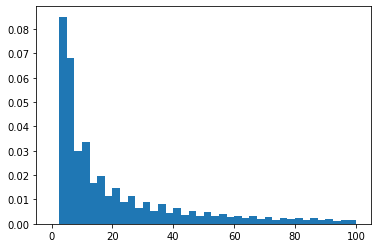

In [42]:
plt.hist(np.array(NV_6["revcount"]),bins=40,range = (0,100),density=True)

In [43]:
NV_6

,name,lon,lat,clusterid,state,county,stars,revcount,avg_income,ct_cat,rounded_stars,binom_stars,const
2,$10 DRESS,-115.152535,36.151508,6,NV,clark county,4.5,8,47090.0,5,4,3,1
3,$10 Tickets,-115.120086,36.034018,6,NV,clark county,2.5,7,47090.0,6,2,1,1
4,$2.50 Cleaners,-115.297143,36.124902,6,NV,clark county,1.5,6,47090.0,5,1,0,1
6,$2 Shoes,-115.137626,36.124447,6,NV,clark county,3.0,17,47090.0,3,3,2,1
10,$99 PC Repair Centers,-115.296334,36.095736,6,NV,clark county,5.0,4,47090.0,7,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152839,Zumiez Fashion Show Mall,-115.168361,36.127019,6,NV,clark county,3.5,6,47090.0,6,3,2,1
152846,Zuri,-115.169277,36.102562,6,NV,clark county,3.0,36,47090.0,3,3,2,1
152850,Zu Yu Xuan Foot Spa,-115.219864,36.125353,6,NV,clark county,5.0,4,47090.0,4,5,4,1
152856,Zvenia & Associates,-115.088115,36.116549,6,NV,clark county,1.0,3,47090.0,2,1,0,1
